In [1]:
from IPython.core.display import HTML
css_file = '../../../../msc/custom.css' 
HTML(open(css_file, 'r').read()) 

# The Generalized Roy Model

**Roadmap**

* Data Generating Process
* Objects of Interest
* Processing Specification
* Setting up Simulation
* Conducting Estimation
* Inspection of Results

Over the next couple of lectures, we will then constantly refine the basic code and explore elements of software engineering such as Object-Oriented Programming, Unit Testing, Debugging, and Profiling.

## Data Generating Process

The generalized Roy model is characterized by the following set of equations. 

**Potential Outcomes**

\begin{align}
Y_1 &= X\beta_1 + U_1 \\
Y_0 &= X\beta_0 + U_0 
\end{align}

**Cost**

\begin{align}
C = Z\gamma + V
\end{align}

**Choice**

\begin{align}
S &= Y_1 - Y_0 - C\\
D &= I[S > 0]
\end{align}

**Observed Outcome**

\begin{align}
Y = D Y_1 + (1 - D)Y_0
\end{align}

$(Y_1, Y_0)$ are objective outcomes associated with each potential treatment state $D$ and realized after the treatment decision. $Y_1$ refers to the outcome in the treated state and $Y_0$ in the untreated state. $C$ denotes the subjective cost of treatment participation. Any subjective benefits,e.g. job amenities, are included (as a negative contribution) in the subjective cost of treatment. Agents take up treatment $D$ if they expect the objective benefit to outweigh the subjective cost. In that case, their subjective evaluation, i.e. the expected surplus from participation $S$, is positive. If agents take up treatment, then the observed outcome $Y$ corresponds to the outcome in the presence of treatment $Y_1$. Otherwise, $Y_0$ is observed. The unobserved potential outcome is referred to as the counterfactual outcome. 

## Objects of Interest

**Individual-specific Treatment Effect**

\begin{align}
B = Y_1 - Y_0 = X(\beta_1 - \beta_0) + (U_1 - U_0)
\end{align}

* Heterogeneity
 * Observed
 * Unobserved
 
**Average Treatment Effect**

\begin{align}
ATE & = E\left[Y_1 - Y_0 \right]\\
TT  & = E\left[Y_1 - Y_0 \mid D = 1\right]\\
TUT & = E\left[Y_1 - Y_0 \mid D = 0\right]
\end{align}

<img src="images/treatment_effects.png">

**Marginal Treatment Effect**

The *MTE* is the treatment effect parameter that conditions on the unobserved desire to select into treatment. Let $V = E[U_C - (U_1 - U_0)| I ]$ summarize the expectations about all unobservables determining treatment choice and let $U_S = F_V (V)$. Then, the *MTE* is defined as

\begin{align}
MTE(x,u_s) = E[Y_1 - Y_0|X = x,U_S = u_s]
\end{align}

<img src="images/marginalRelationships.png">

**Distribution of Potential Outcomes**

\begin{align}
F_{Y_1,Y_0}
\end{align}

* Distribution of Benefits
 * Heterogeneity
 * Population Shares

<img src="images/joint_dist.png">

### Additional Information

For relevant materials, please see the References session at the bottom of the notebook. 

## Processing of Model Specification

We manage the model specification in an external text file, which is called *init.ini*. This file will turn out to be useful to provide the parameters for a simulation of a synthetic sample or the initialization of starting values for an estimation.

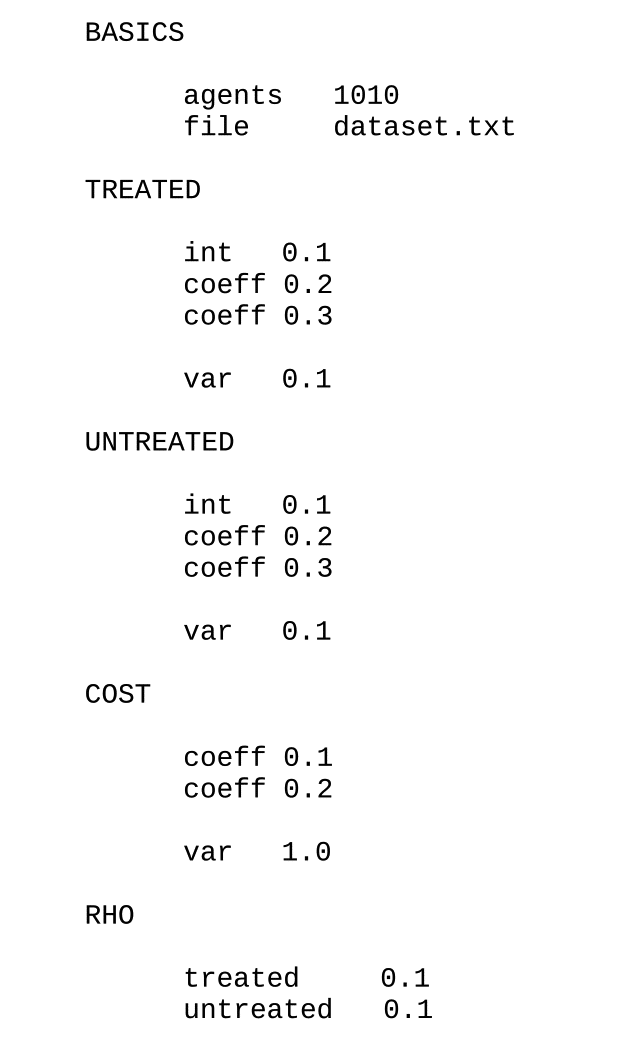

In [1]:
from IPython.display import Image
Image(filename='images/init.png')

Now we will develop a function that processes the initialization file.

In [2]:
import numpy as np


def _check_integrity_process(dict_):
    """ Check integrity of initFile dict.
    """
    # Antibugging
    assert (isinstance(dict_, dict))

    # Check number of agents
    assert (dict_['BASICS']['agents'] > 0)
    assert (isinstance(dict_['BASICS']['agents'], int))

    # Check optimizer
    assert (dict_['ESTIMATION']['optimizer'] in ['bfgs', 'nm'])

    # Check starting values
    assert (dict_['ESTIMATION']['start'] in ['random', 'init', 'zero'])

    # Maximum iterations
    assert (dict_['ESTIMATION']['maxiter'] >= 0)

    # Implementations
    assert (dict_['ESTIMATION']['version'] in ['functional', 'object', 'optimized'])
    assert (dict_['ESTIMATION']['version'] in ['functional'])

    # Finishing
    return True


def _add_auxiliary(dict_):
    """ Add some auxiliary objects.
    """
    # Antibugging
    assert (isinstance(dict_, dict))

    # Initialize container
    dict_['AUX'] = {}

    # Full set of coefficients.
    dict_['TREATED']['all'] = [dict_['TREATED']['int']]
    dict_['TREATED']['all'] += dict_['TREATED']['coeff']
    dict_['TREATED']['all'] = np.array(dict_['TREATED']['all'])

    dict_['UNTREATED']['all'] = [dict_['UNTREATED']['int']]
    dict_['UNTREATED']['all'] += dict_['UNTREATED']['coeff']
    dict_['UNTREATED']['all'] = np.array(dict_['UNTREATED']['all'])

    dict_['COST']['all'] = np.array(dict_['COST']['coeff'])

    # Number of covariates
    num_covars_out = len(dict_['TREATED']['coeff']) + 1
    num_covars_cost = len(dict_['COST']['coeff'])

    dict_['AUX']['num_covars_out'] = num_covars_out
    dict_['AUX']['num_covars_cost'] = num_covars_cost

    # Number of parameters
    dict_['AUX']['num_paras'] = 2 * num_covars_out + num_covars_cost + 2 + 2

    # Starting values
    dict_['AUX']['start_values'] = []
    dict_['AUX']['start_values'] += [dict_['TREATED']['int']]
    dict_['AUX']['start_values'] += dict_['TREATED']['coeff']
    dict_['AUX']['start_values'] += [dict_['UNTREATED']['int']]
    dict_['AUX']['start_values'] += dict_['UNTREATED']['coeff']
    dict_['AUX']['start_values'] += dict_['COST']['coeff']
    dict_['AUX']['start_values'] += [dict_['TREATED']['var']]
    dict_['AUX']['start_values'] += [dict_['UNTREATED']['var']]
    dict_['AUX']['start_values'] += [dict_['RHO']['treated']]
    dict_['AUX']['start_values'] += [dict_['RHO']['untreated']]

    # Finishing
    return dict_


def _process_cases(list_):
    """ Process cases and determine whether keyword or empty
        line.
    """
    # Antibugging
    assert (isinstance(list_, list))

    # Get information
    is_empty = (len(list_) == 0)

    if not is_empty:
        is_keyword = list_[0].isupper()
    else:
        is_keyword = False

    # Antibugging
    assert (is_keyword in [True, False])
    assert (is_empty in [True, False])

    # Finishing
    return is_empty, is_keyword
    return is_empty, is_keyword

In [3]:
import shlex

def process():
    """ This function reads the init.ini file.
    """
    # Initialization
    dict_ = {}

    for line in open('init.ini').readlines():

        list_ = shlex.split(line)

        # Determine special cases
        is_empty, is_keyword = _process_cases(list_)

        # Applicability
        if is_empty:
            continue

        if is_keyword:
            keyword = list_[0]
            dict_[keyword] = {}
            continue

        # Distribute information
        name, val = list_[0], list_[1]

        # Prepare container.
        if name not in dict_[keyword].keys():
            dict_[keyword][name] = None

            if name in ['coeff']:
                dict_[keyword][name] = []

        # Type conversion
        if name in ['agents', 'maxiter']:
            val = int(val)
        elif name in ['file', 'optimizer', 'start', 'version']:
            val = str(val)
        else:
            val = float(val)

        # Collect information
        if name in ['coeff']:
            dict_[keyword][name] += [val]
        else:
            dict_[keyword][name] = val

    # Add auxiliary objects
    dict_ = _add_auxiliary(dict_)

    # Check quality.
    _check_integrity_process(dict_)

    # Finishing.
    return dict_


Let us check if it is all working.

In [4]:
init_dict = process()

# Setting up the Simulation

**Distributinal Assumptions**

*Observables*

\begin{align}
X & \sim \mathbb{N}(0, 1) \\
Z & \sim \mathbb{N}(0, 1) \\
\end{align}

*Unobservables*  

\begin{eqnarray*}
\begin{pmatrix}U_{1}\\
U_{0}\\
V
\end{pmatrix} & \sim & \mathbb{N}\left[\left(\begin{array}{c}
0\\
0\\
0
\end{array}\right),\left(\begin{array}{ccc}
\sigma_{U_1}^2 & 0 & \sigma_{U_1,V}\\
0 & \sigma_{U_0}^2 & \sigma_{U_0,V}\\
\sigma_{U_1,V} & \sigma_{U_0,V} & \sigma_{V}^2
\end{array}\right)\right]\\
\end{eqnarray*}

In [5]:
init_dict = process()

In [6]:
import numpy as np


def _check_integrity_simulate(Y1, Y0, Y, D):
    """ Check quality of simulated sample.
    """
    assert (np.all(np.isfinite(Y1)))
    assert (np.all(np.isfinite(Y0)))

    assert (np.all(np.isfinite(Y)))
    assert (np.all(np.isfinite(D)))

    assert (Y1.dtype == 'float')
    assert (Y0.dtype == 'float')

    assert (Y.dtype == 'float')
    assert (D.dtype == 'float')

    assert (D.all() in [1.0, 0.0])


def _write_out(Y, D, X, Z, file_name):
    """ Write out simulated data to file.
    """

    np.savetxt(file_name, np.column_stack((Y, D, X, Z)), fmt='%8.3f')

In [7]:
import os

def simulate(init_dict):
    """ Simulate a model based on the initialization file.
    """

    # Antibugging
    assert (isinstance(init_dict, dict))

    # Ensure recomputability
    np.random.seed(123)

    # Distribute information
    num_agents = init_dict['BASICS']['agents']
    file_name = init_dict['BASICS']['file']

    Y1_coeffs = init_dict['TREATED']['all']
    Y0_coeffs = init_dict['UNTREATED']['all']

    C_coeffs = np.array(init_dict['COST']['coeff'])

    U1_var = init_dict['TREATED']['var']
    U0_var = init_dict['UNTREATED']['var']

    V_var = init_dict['COST']['var']

    U1V_rho = init_dict['RHO']['treated']
    U0V_rho = init_dict['RHO']['untreated']

    # Auxiliary objects
    U1V_cov = U1V_rho * np.sqrt(U1_var) * np.sqrt(V_var)
    U0V_cov = U0V_rho * np.sqrt(U0_var) * np.sqrt(V_var)

    num_covars_out = Y1_coeffs.shape[0]
    num_covars_cost = C_coeffs.shape[0]

    # Simulate observables
    means = np.tile(0.0, num_covars_out)
    covs = np.identity(num_covars_out)

    X = np.random.multivariate_normal(means, covs, num_agents)
    X[:, 0] = 1.0

    means = np.tile(0.0, num_covars_cost)
    covs = np.identity(num_covars_cost)

    Z = np.random.multivariate_normal(means, covs, num_agents)

    # Construct index of observable characteristics
    Y1_level = np.dot(Y1_coeffs, X.T)
    Y0_level = np.dot(Y0_coeffs, X.T)
    C_level = np.dot(C_coeffs, Z.T)

    # Simulate unobservables
    means = np.tile(0.0, 3)
    vars_ = [U1_var, U0_var, V_var]
    covs = np.diag(vars_)

    covs[0, 2] = U1V_cov
    covs[2, 0] = covs[0, 2]

    covs[1, 2] = U0V_cov
    covs[2, 1] = covs[1, 2]

    U = np.random.multivariate_normal(means, covs, num_agents)

    # Simulate endogenous variables
    Y1 = np.tile(np.nan, num_agents)
    Y0 = np.tile(np.nan, num_agents)
    Y = np.tile(np.nan, num_agents)

    D = np.tile(np.nan, num_agents)

    for i in range(num_agents):
        # Distribute unobservables.
        U1, U0, V = U[i, 0], U[i, 1], U[i, 2]

        # Decision Rule.
        expectedBenefits = Y1_level[i] - Y0_level[i]
        cost = C_level[i] + V

        D[i] = np.float((expectedBenefits - cost > 0))

        # Potential outcomes.
        Y1[i] = Y1_level[i] + U1
        Y0[i] = Y0_level[i] + U0

        # Observed outcomes.
        Y[i] = D[i] * Y1[i] + (1.0 - D[i]) * Y0[i]

    # Check integrity
    _check_integrity_simulate(Y1, Y0, Y, D)

    # Save to disk
    _write_out(Y, D, X, Z, file_name)

    # Return selected features of data
    return Y1, Y0, D

Let us check if it is all working.

In [8]:
init_dict = process()

Y1, Y0, D = simulate(init_dict)


Given our parametrization, let us revisit our objects of interest. We start with the individual-specific benefits. Please note the use of the [StatsModels](http://statsmodels.sourceforge.net/devel/index.html) library,
that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. Think of it as a replacement for using [R](http://www.r-project.org/). In general, [rpy2](http://rpy.sourceforge.net/rpy2.html) provides a low-level interface to R from Python.

Populating the interactive namespace from numpy and matplotlib

Average Treatment Effects

     ATE        0.39

     TT         0.41

     TUT        0.30



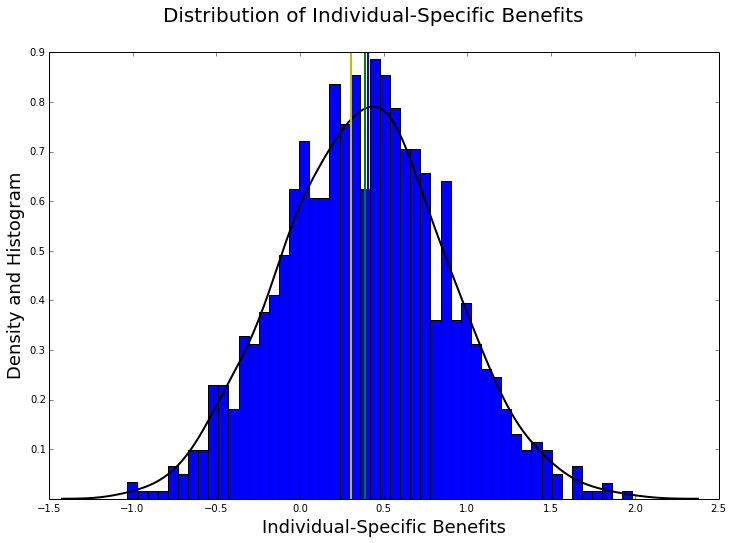

In [9]:
# import of libraries
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%pylab inline

# Auxiliary variables
B = Y1 - Y0

# Create histogram and density estimate of benefits.
kde = sm.nonparametric.KDEUnivariate(B)
kde.fit()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.hist(B, bins=50, normed=True, color='blue')
ax.plot(kde.support, kde.density, lw=2, color='black')
fig.suptitle('Distribution of Individual-Specific Benefits', fontsize=20)
ax.set_xlabel('Individual-Specific Benefits', fontsize=18)
ax.set_ylabel('Density and Histogram', fontsize=18)
yticks = ax.yaxis.get_major_ticks()
yticks[0].set_visible(False)

# Calcuate the average treatment effects
ate, tt, tut = np.mean(B), np.mean(B[D==1]), np.mean(B[D==0])

# Pretty formatting of strings and output
fmt = '     {0:<5}{1:10.2f}\n'

print '\nAverage Treatment Effects\n'
print fmt.format('ATE ', ate)
print fmt.format('TT', tt)
print fmt.format('TUT ', tut)

# Let us add them to our plot.
plt.axvline(x=ate, ymin=0, ymax=5, linewidth=2, color='g')
plt.axvline(x=tt, ymin=0, ymax=5, linewidth=2, color='b')
plt.axvline(x=tut, ymin=0, ymax=5, linewidth=2, color='y')


## Estimation

Now, we will perform Maximum Likelihood Estimation using alternative optimization algorithms. Here is the likelihood function:

\begin{align}
\mathcal{L}(\theta; X, Z) =\sum^N_{i=1} D\mathcal{L_{i,1}} + (1 - D)\mathcal{L_{i,0}},
\end{align}

where

\begin{align}
\mathcal{L_1} = & \log\left(\frac{1}{\sigma_{U_1}}\phi\left(\frac{Y_i - X_i\beta_1}{\sigma_{U_1}}\right)\Phi\left(\frac{Z_i\gamma - \sigma_V/\sigma_{U_1}(Y_i - X_i\beta_1)}{\sqrt{(1 - \rho_{U_1,V})*\sigma^2_{V}}}\right)\right) \\
\mathcal{L_0} =  &\log\left(\frac{1}{\sigma_{U_0}}\phi\left(\frac{Y_i - X_i\beta_0}{\sigma_{U_0}}\right)\Phi\left(\frac{Z_i\gamma - \sigma_V/\sigma_{U_0}(Y_i - X_i\beta_0)}{\sqrt{(1 - \rho_{U_0,V})*\sigma^2_{V}}}\right)\right) \\
\end{align}

In [11]:
from scipy.stats    import norm

def _distribute_parameters(x, num_covars_out):
    """ Distribute the parameters.
    """
    # Antibugging
    assert (isinstance(x, np.ndarray))
    assert (isinstance(num_covars_out, int))
    assert (num_covars_out > 0)

    # Initialize containers
    rslt = dict()

    # Distribute parameters
    rslt['Y1_coeffs'] = x[:num_covars_out]
    rslt['Y0_coeffs'] = x[num_covars_out:(2 * num_covars_out)]

    rslt['C_coeffs'] = x[(2 * num_covars_out):(-4)]

    rslt['U1_var'] = np.exp(x[(-4)])
    rslt['U0_var'] = np.exp(x[(-3)])

    rslt['U1V_rho'] = -1.0 + 2.0 / (1.0 + float(np.exp(-x[-2])))
    rslt['U0V_rho'] = -1.0 + 2.0 / (1.0 + float(np.exp(-x[-1])))

    # Finishing.
    return rslt


def _negative_log_likelihood(args, Y, D, X, Z):
    """ Negative Log-likelihood function of the Generalized Roy Model.
    """
    # Distribute parametrization
    Y1_coeffs = np.array(args['Y1_coeffs'])
    Y0_coeffs = np.array(args['Y0_coeffs'])

    C_coeffs = np.array(args['C_coeffs'])

    U1_var = args['U1_var']
    U0_var = args['U0_var']

    U1V_rho = args['U1V_rho']
    U0V_rho = args['U0V_rho']

    # Auxiliary objects.
    num_agents = Y.shape[0]
    choiceCoeffs = np.concatenate((Y1_coeffs - Y0_coeffs, - C_coeffs))

    # Likelihood construction.
    likl = 0.00

    for i in range(num_agents):

        G = np.concatenate((X[i, :], Z[i, :]))
        idx = np.dot(choiceCoeffs, G)

        if D[i] == 1.00:

            coeffs = Y1_coeffs
            rho = U1V_rho
            sd = np.sqrt(U1_var)

        else:

            coeffs = Y0_coeffs
            rho = U0V_rho
            sd = np.sqrt(U0_var)

        arg_one = (Y[i] - np.dot(coeffs, X[i, :])) / sd
        arg_two = (idx - rho * arg_one) / np.sqrt(1.0 - rho ** 2)

        cdf_evals = norm.cdf(arg_two)
        pdf_evals = norm.pdf(arg_one)

        if D[i] == 1.0:

            contrib = (1.0 / float(sd)) * pdf_evals * cdf_evals

        else:

            contrib = (1.0 / float(sd)) * pdf_evals * (1.0 - cdf_evals)

        contrib = np.clip(contrib, 1e-20, 1.0)

        likl += -np.log(contrib)

    likl *= (1.0 / float(num_agents))

    # Quality checks.
    assert (isinstance(likl, float))
    assert (np.isfinite(likl))

    # Finishing.
    return likl


def _load_data():
    """ Load dataset.
    """
    init_dict = process()

    # Auxiliary objects
    num_covars_out = init_dict['AUX']['num_covars_out']
    num_covars_cost = init_dict['AUX']['num_covars_cost']

    # Read dataset
    data = np.genfromtxt(init_dict['BASICS']['file'])

    # Distribute data
    Y, D = data[:, 0], data[:, 1]

    X, Z = data[:, 2:(num_covars_out + 2)], data[:, -num_covars_cost:]

    # Finishing
    return Y, D, X, Z


def _max_interface(x, Y, D, X, Z):
    """ Interface to the SciPy maximization routines.
    """
    # Auxiliary objects.
    num_covars_out = X.shape[1]

    # Collect maximization arguments.
    rslt = _distribute_parameters(x, num_covars_out)

    # Calculate likelihood.
    likl = _negative_log_likelihood(rslt, Y, D, X, Z)

    # Finishing.
    return likl


def _get_start(which, init_dict):
    """ Get different kind of starting values.
    """
    # Antibugging.
    assert (which in ['zeros', 'random', 'init'])

    # Distribute auxiliary objects
    num_paras = init_dict['AUX']['num_paras']

    # Select relevant values.
    if which == 'random':
        x0 = np.random.uniform(size=num_paras)

        # Variances
        x0[(-4)] = max(x0[(-4)], 0.01)
        x0[(-3)] = max(x0[(-3)], 0.01)

        # Correlations
        x0[(-2)] -= - 0.5
        x0[(-1)] -= - 0.5

    elif which == 'init':
        x0 = init_dict['AUX']['start_values'][:]
    else:
        raise AssertionError

    # Transform to real line
    x0 = _transform_start(x0)

    # Quality assurance.
    assert (np.all(np.isfinite(x0)))

    # Finishing.
    return x0


def _transform_start(x):
    """ Transform starting values to cover the whole real line.
    """
    
    # Coefficients
    x[:(-4)] = x[:(-4)]

    # Variances
    x[(-4)] = np.log(x[(-4)])
    x[(-3)] = np.log(x[(-3)])

    # Correlations
    x[(-2)] = -np.log(-1.0 + 2.0/(x[(-2) + 1]))
    x[(-1)] = -np.log(-1.0 + 2.0/(x[(-1) + 1]))
    
    # Finishing
    return x

Let us evaluate the criterion function and see if that part is working.

In [12]:
# Load model information
init_dict  = process() 

Y, D, X, Z = _load_data()

'Set up the parametrization. '
args = {}

args['Y1_coeffs'] = np.array(init_dict['TREATED']['all'])
args['Y0_coeffs'] = np.array(init_dict['UNTREATED']['all'])

args['C_coeffs'] = np.array(init_dict['COST']['all'])

args['U1_var']  = init_dict['TREATED']['var']
args['U0_var']  = init_dict['UNTREATED']['var']

args['U1V_rho'] = init_dict['RHO']['treated']
args['U0V_rho'] = init_dict['RHO']['untreated']

likl = _negative_log_likelihood(args, Y, D, X, Z)

print 'Evaluation of criterion function', likl

Evaluation of criterion function 0.758190249087


Finally, we create a function for the estimation. It builds on all our previously defined elements.

In [13]:
from scipy.optimize import minimize

def estimate(init_dict):
    """ Estimate the generalized Roy model.
    """

    # Antibugging
    assert (isinstance(init_dict, dict))

    # Load dataset
    Y, D, X, Z = _load_data()

    # Create auxiliary objects
    start = init_dict['ESTIMATION']['start']
    maxiter = init_dict['ESTIMATION']['maxiter']

    optimizer = init_dict['ESTIMATION']['optimizer']

    # Initialize different starting valuesinit_dict['AUX']['start_values'].copy()
    x0 = _get_start(start, init_dict)

    # Call alternative optimizers
    opts = dict()

    opts['maxiter'] = maxiter

    # Select optimizer
    if optimizer == 'nm':

        optimizer = 'Nelder-Mead'

    elif optimizer == 'bfgs':

        optimizer = 'BFGS'

    rslt = minimize(_max_interface, x0, args=(Y, D, X, Z),
                    method=optimizer, options=opts)

    # Tranformation to internal parameters
    num_covars_out = init_dict['AUX']['num_covars_out']

    parameters = _distribute_parameters(rslt['x'], num_covars_out)

    # Finishing
    return parameters

Let us now run the estimation and select different starting values and optimzers.

In [14]:
# Process model specification
init_dict = process()

# Simulate a synthetic sample
simulate(init_dict)

# Estimate the generalized Roy model
for optimizer in ['bfgs', 'nm']:
    
    init_dict['ESTIMATION']['optimizer'] = optimizer
    
    for start in ['random', 'init']:
        
        init_dict['ESTIMATION']['start'] = start

        # Monitoring
        print '\n\n Current Request \n'
        
        print ' Optimizer: ', optimizer
        
        print ' Start:     ', start
        
        # Run estimation
        parameters = estimate(init_dict)
        
        # Inspect subset of results
        print ' Variances: ', parameters['U1_var'], parameters['U0_var']
        




 Current Request 

 Optimizer:  bfgs
 Start:      random
 Variances:  0.635604690434 0.904945129463


 Current Request 

 Optimizer:  bfgs
 Start:      init
 Variances:  0.110507242746 0.110481805113


 Current Request 

 Optimizer:  nm
 Start:      random
 Variances:  0.687153654787 0.425940520917


 Current Request 

 Optimizer:  nm
 Start:      init
 Variances:  0.1 0.11


## Inspection of Results

After conduction an estimation, the focus shifts back to the economic interpretation of our results. As we often have to study the results from hundreds of different estimation runs, it is convenient to have a function set up that produces the main objects of interest. 

In [15]:
raise NotImplementedError, "I just decided to add this and will do so in the next couple of days. "

## Cleanup

In [16]:
try:
    
    os.remove('dataset.txt')
    
except OSError:
    
    pass

## References

Aakvik, A., Heckman, J. J., and Vytlacil, E. J. (2005). Treatment Effects for Discrete Outcomes When Responses to Treatment Vary Among Observationally Identical Persons: An Application to Norwegian Vocational Rehabilitation Programs. *Journal of Econometrics*, 125(1-2):15–51.

Abbring, J. and Heckman, J. J. (2007). Econometric Evaluation of Social Programs, Part III: Distributional Treatment Effects, Dynamic Treatment Effects, Dynamic Discrete Choice, and General Equilibrium Policy Evaluation. In Heckman, J. J. and Leamer, E. E., editors, *Handbook of Econometrics*, volume 6B, pages 5145–5303. Elsevier Science, Amsterdam, Netherlands

Browning, M., Heckman, J. J., and Hansen, L. P. (1999). Micro Data and General Equilibrium Models. In Taylor, J. B. and Woodford, M., editors, *Handbook of Macroeconomics*, volume 1A, pages 543–633. Elsevier Science, Amsterdam, Netherlands.

Carneiro, P., Hansen, K., and Heckman, J. J. (2003). Estimating Distributions of Treatment Effects with an Application to the Returns to Schooling and Measurement of the Effects of Uncertainty on College Choice. *International Economic Review*, 44(2):361–422.

Eisenhauer, P. (2012). Issues in the Economics and Econometrics
of Policy Evaluation: Explorations Using a Factor Structure Model. Unpublished Manuscript.

Heckman, J. J. (2001). Micro Data, Heterogeneity, and the Evaluation of Public Policy: Nobel Lecture. *Journal of Political Economy*, 109(4):673–748.

Heckman, J. J., Smith, J., and Clements, N. (1997). Making the Most Out of Programme Evaluations and Social Experiments: Accounting for Heterogeneity in Programme Impacts. *The Review of Economic Studies*, 64(4):487–535.

Heckman, J. J. and Vytlacil, E. J. (2007a). Econometric Evaluation of Social Programs, Part I: Causal Effects, Structural Models and Econometric Policy Evaluation. In Heckman, J. J. and Leamer, E. E., editors, *Handbook of Econometrics*, volume 6B, pages 4779–4874. Elsevier Science, Amsterdam, Netherlands.

Heckman, J. J. and Vytlacil, E. J. (2007b). Econometric Evaluation of Social Programs, Part II: Using the Marginal Treatment Effect to Organize Alternative Economic Estimators to Evaluate Social Programs and to Forecast their Effects in New Environments. In Heckman, J. J. and Leamer, E. E., editors, *Handbook of Econometrics*, volume 6B, pages 4875–5144. Elsevier Science, Amsterdam, Netherlands.

Quandt, R. E. (1958). The Estimation of the Parameters of a Linear Regression System Obeying two Separate Regimes. *Journal of the American Statistical Association*, 53(284):873–880.

Quandt, R. E. (1958). The Estimation of the Parameters of a Linear Regression System Obeying two Separate Regimes. *Journal of the American Statistical Association*, 53(284):873–880.